In [51]:
from PIL import Image
from PIL import ImageDraw
import numpy as np
import random

In [2]:
## Find the endpoint of a line segment with given start coordinate (x,y), angle (in radians) and distance
### returns endpoint with x and y values rounded to (closest?) integer, optional argument if angle given in degrees
def line_segment_endpoint(coord, angle, dist, degrees = False):
    if degrees == True:
        angle = angle * np.pi/180
        return (int(dist*np.cos(angle) + coord[0]), int(dist*np.sin(angle) + coord[1]))
    else:
        return (int(dist*np.cos(angle) + coord[0]), int(dist*np.sin(angle) + coord[1]))



In [3]:
#  Find angle between two points, output is in radians
def angle_between(pt1,pt2):
    if pt1 == pt2:
        return 0
    if pt1[1] <= pt2[1]:
        (x1, y1) = pt1
        (x2, y2) = pt2
        adjacent = x2-x1 
        hypot = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        return np.arccos(adjacent/hypot)
    if pt1[1] > pt2[1]:
        (x1, y1) = pt1
        (x2, y2) = pt2
        adjacent = x2-x1 
        hypot = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        return 2*np.pi - np.arccos(adjacent/hypot)



In [4]:
def dist_betw_points(p1,p2):
    dist = np.sqrt((p2[0]-p1[0])**2 + (p2[1]-p1[1])**2)
    return dist



In [5]:
#  Creates a quadrilateral that takes two points, a perspective point, edge color and face color, depth
#  pt_pair = ((x1,y1),(x2,y2))

def perspective_quad(drawable, pt_pair, depth, persp_pt = (0,0), edge_color = (255,255,255), face_color = (0,0,0)):
    depth_pts = []
    for pt in pt_pair:
        depth_pts.append(line_segment_endpoint(pt, angle_between(pt, persp_pt), depth))
    quad_pts = [pt_pair[0], pt_pair[1], depth_pts[1], depth_pts[0]]
    drawable.polygon(quad_pts, fill=face_color, outline=edge_color)



In [6]:
# The following takes as an input two points (p1, p2), a perspective point (persp_pt), and a second point on the line from p1 to persp_pt (b1)
# Output is then given as a point b2 that is on the line from p2 to persp_pt such that it is the intersection point with the line paralel to line(p1,p2) through b1

# This function can accept b1 both closer to the persp_pt than p1 or further away so can be sued for many different problems 

# Account for the following problems that could pop up: What if p1 = p2, p2 = persp_pt, or p1 = persp_pt?
#                                                       What if any of the given points points share an x-value, making the slope infinite?

def parallel_intersection(p1,p2,b1,persp_pt):
    
    # Need to start with a clause making sure I'm not dividing by zero
    
    if (p1[0] != p2[0]) and (p2[0] != persp_pt[0]):
        
        # Within this I need to check if the points are colinear
        # Find the slopes for each of the line segments
        
        m1 = (p2[1] - p1[1]) / (p2[0] - p1[0])
        m2 = (p2[1] - persp_pt[1]) / (p2[0] - persp_pt[0])
        
        # Find the x and y values of the new point
        
        if m1 != m2:
            
            x = (b1[1] - p2[1] + m2*p2[0] - m1*b1[0]) / (m2 - m1)
            y = p2[1] + m2*x - m2*p2[0]
            return (x,y)
        
        #Case: Colinear points
        
        else:
            
            delta_x = b1[0] - p1[0]
            delta_y = b1[1] - p1[1]
            
            return (p2[0] + delta_x, p2[1] + delta_y)
    
    # Case: p1 and p2 have the same x-value, the same is not true for p2 and persp_pt
    
    if (p1[0] == p2[0]) and (p2[0] != persp_pt[0]):
        
        m2 = (p2[1] - persp_pt[1]) / (p2[0] - persp_pt[0])
        x = b1[0]
        y = p2[1] + m2*(x - p2[0])
            
        return (x,y)
    
    # Case: p2 and persp_pt share an x-value, the same is not true for p1 and p2
    
    if (p1[0] != p2[0]) and (p2[0] == persp_pt[0]):
        
        m1 = (p2[1] - p1[1]) / (p2[0] - p1[0])
        x = p2[0]
        y = b1[1] + m1*(x - b1[0])
        
        return (x,y)
    
    # Case: Somehow all three points are collinear and share an x-value
    
    if (p1[0] == p2[0] == perst_pt[0]):
        
        delta_y = b1[1] - p1[1]
        
        return (p2[0], p2[1] + delta_y)



In [10]:
# The following takes a single point (p1), and a perspective point (persp_pt), along with a depth 
# It outputs a point that is a distance away from p1 that is collinear with p1 and persp_pt

def perspective_depth(p1, persp_pt, depth):
    angle = angle_between(p1,persp_pt)
    return line_segment_endpoint(p1, angle, depth, degrees = False)



In [8]:
# perspective_gon redone

def perspective_gon_setdepth(drawable, vertex_list, depth, persp_pt = (0,0), surface = True, edge_color = (255,255,255), surface_color = (0,0,0), side_color = (0,0,0)):
    
    #  Borrowing from the first we create a dictionary for each vertex that gives some of it's attributes: name (vertex), distance from perspective point (distance)
    #  It also includes the points neighbors (neighbors), it should also include the vertex that approaches the perspective point
    
    vertices = []
    
    #  Create the dictionaries, with names, neighbors and distance from persp_pt
    
    for vertex in vertex_list:
        vertex_dict = {}
        vertex_dict['vertex'] = vertex  
        (x1,y1) = vertex
        (x2,y2) = persp_pt
        distance = np.sqrt((x1-x2)**2 + (y1-y2)**2)
        vertex_dict['distance'] = distance
        vertex_dict['neighbors'] = [vertex_list[(vertex_list.index(vertex)-1) % len(vertex_list)], vertex_list[(vertex_list.index(vertex)+1) % len(vertex_list)]]
        vertices.append(vertex_dict)
    
    #  Take the first listed vertex and use that to start finding the vertices that create depth
    
    # perspective_depth(p1, persp_pt, depth_prop)
    b1 = perspective_depth_set(vertices[0]['vertex'], persp_pt, depth)
    depth_list = []
    depth_list.append(b1)
    
    for i in range(len(vertex_list[1:])):
        b = parallel_intersection(vertex_list[i], vertex_list[i+1], depth_list[i], persp_pt)
        depth_list.append(b)
    
    #  Sort the vertices list by furthest vertex
    
    def myFunc(e):
        return e['distance']
    
    vertices.sort(key = myFunc)
    vertices.reverse()
    
    #  Draw polygons on each side starting with the furthest back
    i = 0
    
    for vertex in vertices:
        
        if dist_betw_points(vertex['neighbors'][0], persp_pt) >= dist_betw_points(vertex['neighbors'][1], persp_pt):
            # Draw neighbor 0 before neighbor 1
            # ImageDraw.polygon(xy, fill=None, outline=None)
            
            index = vertex_list.index(vertex['vertex'])
            drawable.polygon([vertex['vertex'], depth_list[index], depth_list[(index-1)%len(vertex_list)], vertex_list[(index-1)%len(vertex_list)]], fill = side_color, outline = edge_color)
            drawable.polygon([vertex['vertex'], depth_list[index], depth_list[(index+1)%len(vertex_list)], vertex_list[(index+1)%len(vertex_list)]], fill = side_color, outline = edge_color)
        else:
            # Draw neighbor 1 before neighbor 0
            
            index = vertex_list.index(vertex['vertex'])
            drawable.polygon([vertex['vertex'], depth_list[index], depth_list[(index+1)%len(vertex_list)], vertex_list[(index+1)%len(vertex_list)]], fill = side_color, outline = edge_color)
            drawable.polygon([vertex['vertex'], depth_list[index], depth_list[(index-1)%len(vertex_list)], vertex_list[(index-1)%len(vertex_list)]], fill = side_color, outline = edge_color)
            
            
    
    #  Draw the surface polygon
    if surface == True:
        drawable.polygon(vertex_list, fill = surface_color, outline = edge_color)

In [11]:
#
def create_face(pt_pair, depth, persp_pt):
    b1 = perspective_depth(pt_pair[0], persp_pt, depth)
    b2 = parallel_intersection(pt_pair[0],pt_pair[1],b1,persp_pt)
    return (pt_pair[0],b1,b2,pt_pair[1])

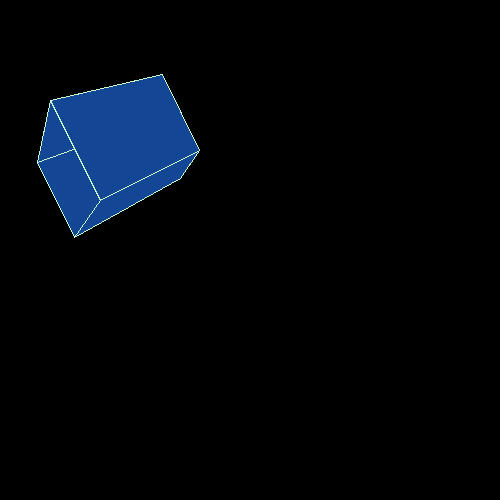

In [24]:
image = Image.new('RGB', (500,500))
draw = ImageDraw.Draw(image)
edge_color = (200,250,200)
surface = False
surface_color = (70,30,20)
side_color = (20,70,150)
p1 = (50,100)
p2 = (100,200)
persp_p1 = (0,350)
persp_p2 = (500,0)
depth = (1/4)* dist_betw_points(p1,persp_p1)
face1 = create_face((p1,p2),depth,persp_p1)
#perspective_gon_setdepth(drawable, vertex_list, depth, persp_pt = (0,0), surface = True, edge_color = (255,255,255), surface_color = (0,0,0), side_color = (0,0,0))
depth = (1/4)*dist_betw_points(p1,persp_p2)
perspective_gon_setdepth(draw, face1, depth, persp_p2, surface, edge_color, surface_color, side_color)
image

In [42]:
# takes as input, a drawable, a point pair, two perspective points, two depths (one for each perspective point)
# edge_color and surface_color
def two_point_persp_cube(drawable, pt_pair, persp_p1, persp_2, depth1, depth2, edge_color, surface_color):
    face = create_face(pt_pair, depth1, persp_p1)
    surface = True
    perspective_gon_setdepth(drawable, face, depth2, persp_p2, surface, edge_color, surface_color, surface_color)

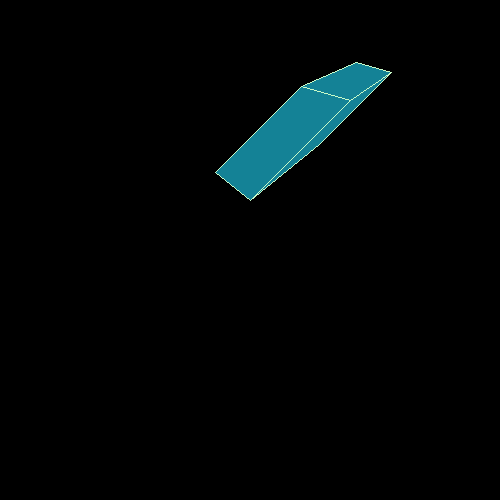

In [43]:
image = Image.new('RGB', (500,500))
draw = ImageDraw.Draw(image)
edge_color = (200,250,200)
surface_color = (20,130,150)
p1 = (350,100)
p2 = (250,200)
persp_p1 = (0,0)
persp_p2 = (500,0)
pt_pair = (p1,p2)
depth1 = 50
depth2 = 50
two_point_persp_cube(draw, pt_pair, persp_p1, persp_p2, depth1, depth2, edge_color, surface_color)
image

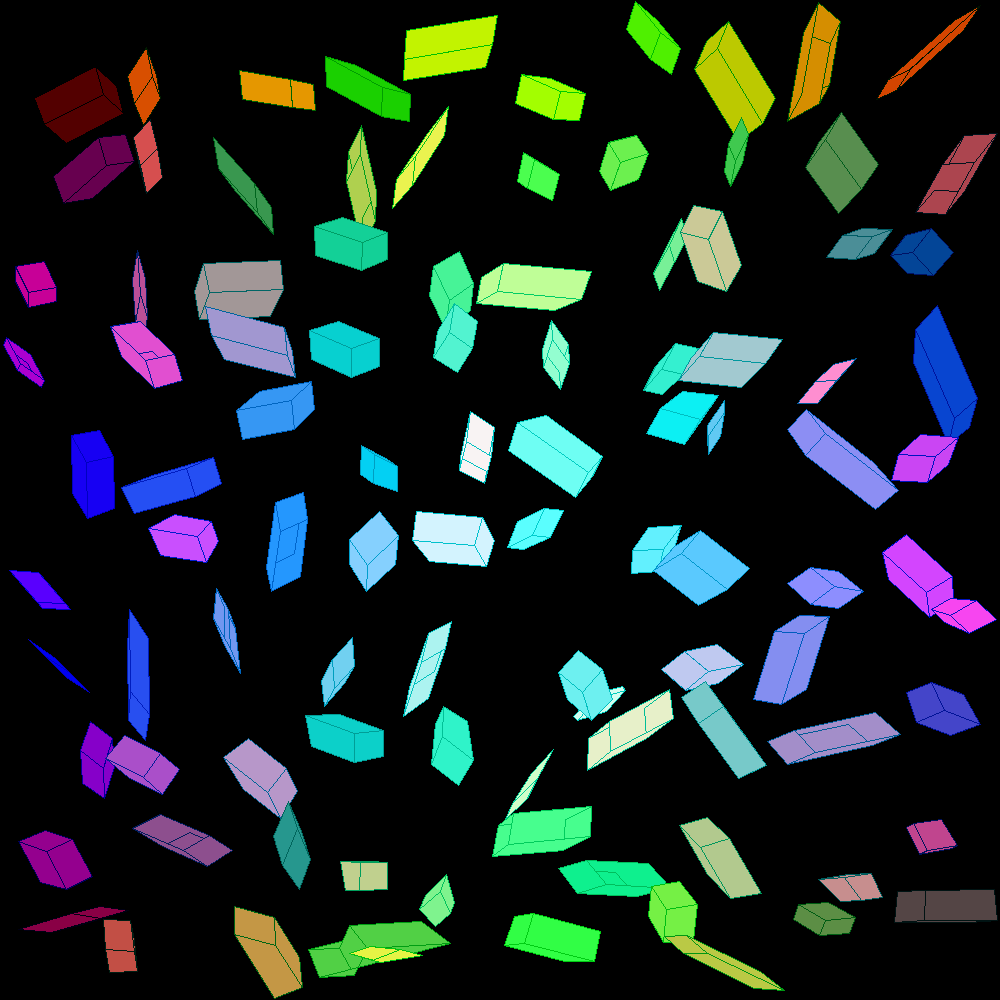

In [65]:
image = Image.new('RGB', (1000,1000))
draw = ImageDraw.Draw(image)
depth1 = 30
depth2 = 30
persp_p1 = (random.randint(0,1000), random.randint(0,1000) )

for i in range(10):
    for j in range(10):
        p1 = (100*i + random.randint(0,100) , 100*j + random.randint(0,100))
        p2 = (100*i + random.randint(0,100), 100*j+ random.randint(0,100))
        persp_p2 = (random.randint(0,1000),random.randint(0,1000))
        pt_pair = (p1,p2)
        surface_color = (random.randint(0,255), int(255*np.sin(i/np.pi)), int(255*np.sin(j/np.pi)))
        edge_color = (0,surface_color[1] -50,surface_color[2] -50)
        two_point_persp_cube(draw, pt_pair, persp_p1, persp_p2, depth1, depth2, edge_color, surface_color)
image

In [66]:
image.save('random_two_pt_showcase.png')